In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

In [2]:
# load in data
df = pd.read_csv("/Users/praswishbasnet/Desktop/Heart-Disease-Prediction/data/heart_disease_data.csv")



In [3]:
print(df.columns)


Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


In [4]:
# Step 2: Define Features and Target Variable
X = df.drop(columns=['HeartDisease'])  # Features
y = df['HeartDisease']  # Target variable

In [9]:
# Step 3: Handle Categorical Variables (One-Hot Encoding)
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [11]:
# Step 4: Feature Selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)  # Selecting top 10 features
X_selected = selector.fit_transform(preprocessor.fit_transform(X), y)

selected_indices = selector.get_support(indices=True)
selected_feature_names = np.array(preprocessor.get_feature_names_out())[selected_indices]

print("Top 10 Selected Features:")
print(selected_feature_names)

Top 10 Selected Features:
['num__Age' 'num__Cholesterol' 'num__FastingBS' 'num__MaxHR'
 'num__Oldpeak' 'cat__Sex_M' 'cat__ChestPainType_ATA'
 'cat__ExerciseAngina_Y' 'cat__ST_Slope_Flat' 'cat__ST_Slope_Up']


In [13]:
# Step 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [15]:
# Step 6: Model Selection and Hyperparameter Tuning using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization parameter

In [17]:
log_reg = LogisticRegression(solver='liblinear')
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [19]:
# Step 7: Train the Best Model
best_log_reg = LogisticRegression(**best_params, solver='liblinear')
best_log_reg.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [21]:
# Step 8: Model Evaluation
y_train_pred = best_log_reg.predict(X_train)
y_test_pred = best_log_reg.predict(X_test)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Training Precision:", precision_score(y_train, y_train_pred))
print("Testing Precision:", precision_score(y_test, y_test_pred))
print("Training Recall:", recall_score(y_train, y_train_pred))
print("Testing Recall:", recall_score(y_test, y_test_pred))
print("Training F1-score:", f1_score(y_train, y_train_pred))
print("Testing F1-score:", f1_score(y_test, y_test_pred))

Training Accuracy: 0.8692098092643051
Testing Accuracy: 0.8315217391304348
Training Precision: 0.8710462287104623
Testing Precision: 0.88
Training Recall: 0.8927680798004988
Testing Recall: 0.822429906542056
Training F1-score: 0.8817733990147784
Testing F1-score: 0.8502415458937198


In [23]:
# Step 9: Cross-Validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_log_reg, X_selected, y, cv=k_fold, scoring='accuracy')
print("Cross-Validation Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Mean Accuracy: 0.863791874554526


In [25]:
# Step 10: Save and Load Model
filename = 'heart_disease_model.sav'
pickle.dump(best_log_reg, open(filename, 'wb'))

loaded_model = pickle.load(open('heart_disease_model.sav', 'rb'))

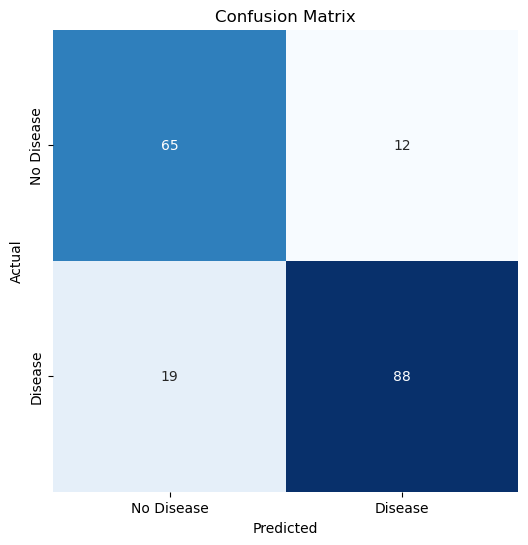

In [27]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

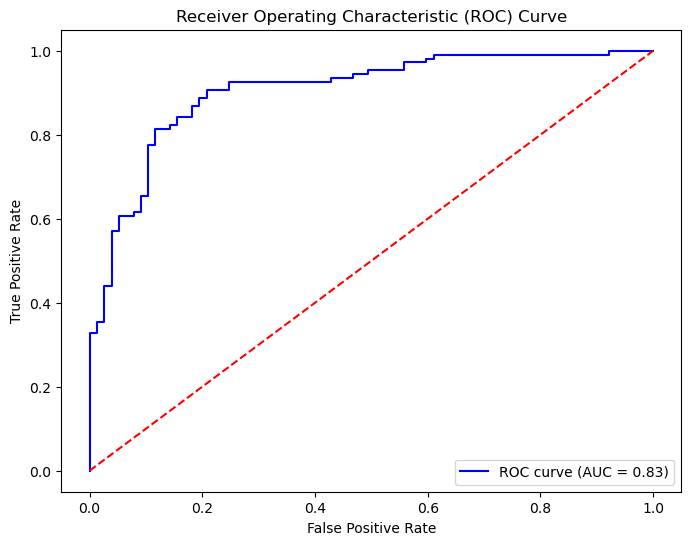

In [29]:
# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_log_reg.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


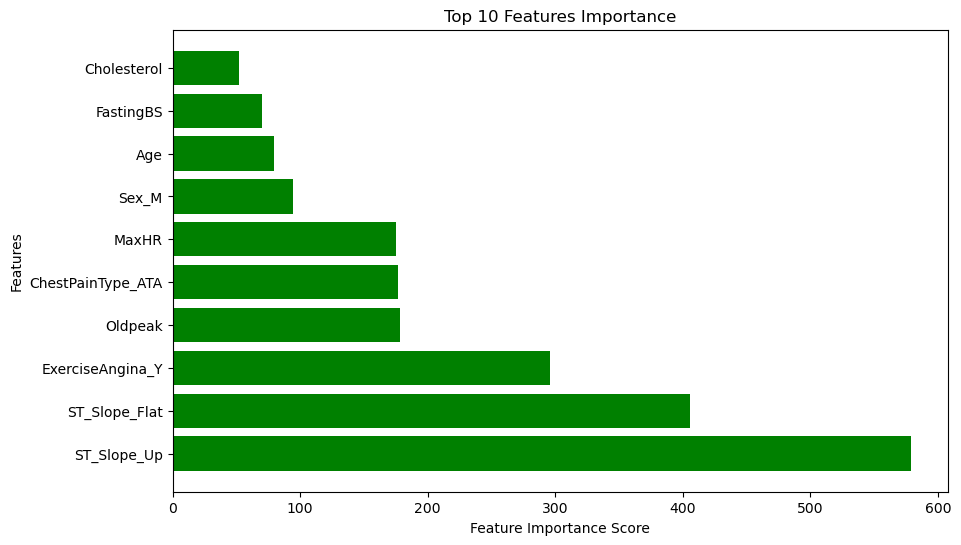

In [35]:
# 3. Feature Importance (Top 10 Selected Features)
feature_importance = selector.scores_
features = numerical_features + preprocessor.transformers_[1][1].get_feature_names_out().tolist()
# Bar plot for feature importance
top_features = sorted(zip(features, feature_importance), key=lambda x: x[1], reverse=True)[:10]
top_features_names, top_features_scores = zip(*top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features_names, top_features_scores, color='green')
plt.title("Top 10 Features Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()